First `import` the dependencies. We are using dask distributed client to run the program on dask worker nodes. Edit the `dask_client.py` file to change the options for the dask scheduler

In [2]:
#!/usr/bin/env python3

import dask.dataframe as df
from dask.distributed import Client, progress

Next we read the bigquery export from the json file.

In [3]:
def read_json_as_dataframe(path):
    return df.read_json(path)

client = Client('10.200.107.9:8786')
client.restart()
# , n_workers=3, threads_per_worker=4, memory_limit='10GB')
client.get_versions(check=True)
json_data = read_json_as_dataframe('/home/ubuntu/data/json/bq-results-20190611.json')

Now lets explore and see the data types and print the head

In [ ]:
json_data.head()

In [72]:
json_data.dtypes

app_info                          object
device                            object
event_name                        object
event_params                      object
event_previous_timestamp         float64
event_server_timestamp_offset      int64
event_timestamp                    int64
geo                               object
user_first_touch_timestamp         int64
user_properties                   object
user_pseudo_id                    object
project_id                        object
subject_id                        object
source_id                         object
human_readable_id                 object
enrolment_date                    object
first_open_time                    int64
firebase_event_origin             object
firebase_screen                   object
engagement_time_msec               int64
button                            object
questionnaire_type                object
questionnaire_timestamp           object
error                             object
error_message   

Print the column names

In [ ]:
json_data.columns

In [ ]:
def sort_and_group(sort_by, group_by):
    return json_data.set_index(sort_by).groupby(group_by)

In [ ]:
users = sort_and_group('user_first_touch_timestamp','user_pseudo_id')['event_timestamp', 'user_properties']

In [ ]:
users.mean().head()

In [ ]:
count_per_user = users.count()

In [ ]:
count_per_user.head()

In [ ]:
count_per_user.event_timestamp.max().compute()

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
plt.hist(count_per_user.event_timestamp.to_dask_array(), bins=20)
plt.show()

In [ ]:
del counts_per_user

In [ ]:
del users

Now lets do some transformations like unnesting the user properties values and adding the appropriate columns

In [ ]:
#json_data.persist()

In [4]:

# Currently only works for int or string values
def get_keys(json_d, keys, int_values):
    display(json_d)
    user_props_dict = dict()
    for kv in json_d.loc[0]:
        if(kv['key'] in keys):
            if(kv['key'] in int_values):
                user_props_dict[kv['key']] = int(kv['value']['int_value'])
            else:
                user_props_dict[kv['key']] = kv['value']['string_value']
    return user_props_dict

# Currently only works for int or string values
# Specify multiple keys if want to add values from 2 different columns to a single one. 
# If both contain values then returns the first one found
def get_key(json_d, keys, type_o):
    for kv in json_d:
        if(kv['key'] in keys):
            if(type_o == int):
                return int(kv['value']['int_value'])
            else:
                return kv['value']['string_value']
    
    
# Applies the lambda to each value.
project_id = json_data.user_properties.apply(lambda x: get_key(x, ['projectId'], str), meta=str)
subject_id = json_data.user_properties.apply(lambda x: get_key(x, ['subjectId'], str), meta=str)
source_id = json_data.user_properties.apply(lambda x: get_key(x, ['sourceId'], str), meta=str)
human_readable_id = json_data.user_properties.apply(lambda x: get_key(x, ['humanReadableId'], str), meta=str)
enrolment_date = json_data.user_properties.apply(lambda x: get_key(x, ['enrolmentDate'], str), meta=str)
first_open_time = json_data.user_properties.apply(lambda x: get_key(x, ['first_open_time'], int), meta=int)


# Currenlty not extracted - firebase_previous_screen, 
firebase_event_origin = json_data.event_params.apply(lambda x: get_key(x, ['firebase_event_origin'], str), meta=str)
firebase_screen = json_data.event_params.apply(lambda x: get_key(x, ['firebase_screen'], str), meta=str)
engagement_time_msec = json_data.event_params.apply(lambda x: get_key(x, ['engagement_time_msec'], int), meta=int)
button = json_data.event_params.apply(lambda x: get_key(x, ['button'], str), meta=str)
questionnaire_type = json_data.event_params.apply(lambda x: get_key(x, ['type', 'name'], str), meta=str)
questionnaire_timestamp = json_data.event_params.apply(lambda x: get_key(x, ['questionnaire_timestamp'], str), meta=str)
error = json_data.event_params.apply(lambda x: get_key(x, ['error', 'error_value'], str), meta=str)
error_message = json_data.event_params.apply(lambda x: get_key(x, ['message'], str), meta=str)

# add unnested user props
json_data = json_data.assign(project_id=project_id, subject_id=subject_id, source_id=source_id, human_readable_id=human_readable_id, enrolment_date=enrolment_date, first_open_time=first_open_time)

# add unnested event params
json_data = json_data.assign(firebase_event_origin=firebase_event_origin, firebase_screen=firebase_screen, engagement_time_msec=engagement_time_msec, button=button, questionnaire_type=questionnaire_type, questionnaire_timestamp=questionnaire_timestamp, error=error, error_message=error_message)

In [4]:
json_data[['subject_id','project_id', 'questionnaire_type']].head()

,subject_id,project_id,questionnaire_type
0,b7564f48-1bf4-4d9e-9925-e165a9325885,RADAR-MSDep-OSR-s1,None
1,b7564f48-1bf4-4d9e-9925-e165a9325885,RADAR-MSDep-OSR-s1,PDQ
2,b7564f48-1bf4-4d9e-9925-e165a9325885,RADAR-MSDep-OSR-s1,THINC-IT
3,b7564f48-1bf4-4d9e-9925-e165a9325885,RADAR-MSDep-OSR-s1,completion_log
4,b7564f48-1bf4-4d9e-9925-e165a9325885,RADAR-MSDep-OSR-s1,completion_log


In [5]:
# copy the dataframe so as to not mutate the original one
unnested_df = json_data.copy()

In [6]:
del json_data

In [7]:
# Remove the columns that have been unnested
unnested_df = unnested_df.drop(['event_params', 'user_properties'], axis=1)  #.compute()

In [7]:
unnested_df.head()

,app_info,device,event_name,event_previous_timestamp,event_server_timestamp_offset,event_timestamp,geo,user_first_touch_timestamp,user_pseudo_id,project_id,...,enrolment_date,first_open_time,firebase_event_origin,firebase_screen,engagement_time_msec,button,questionnaire_type,questionnaire_timestamp,error,error_message
0,"{'id': 'org.phidatalab.radar_armt', 'version':...","{'category': 'mobile', 'mobile_brand_name': 'S...",notification_rescheduled,1.557915e+15,226492,1558642464691001,"{'continent': 'Europe', 'country': 'Italy', 'r...",1554974912733000,e90f9e199b8dd4f8756f46e29bc9934b,RADAR-MSDep-OSR-s1,...,1554884949688,1554976800000,app,None,NaN,None,None,None,None,None
1,"{'id': 'org.phidatalab.radar_armt', 'version':...","{'category': 'mobile', 'mobile_brand_name': 'S...",prepared_kafka_object,1.557915e+15,226492,1558642465541002,"{'continent': 'Europe', 'country': 'Italy', 'r...",1554974912733000,e90f9e199b8dd4f8756f46e29bc9934b,RADAR-MSDep-OSR-s1,...,1554884949688,1554976800000,app,None,NaN,None,PDQ,1558515600000,None,None
2,"{'id': 'org.phidatalab.radar_armt', 'version':...","{'category': 'mobile', 'mobile_brand_name': 'S...",prepared_kafka_object,1.558642e+15,226492,1558642465544003,"{'continent': 'Europe', 'country': 'Italy', 'r...",1554974912733000,e90f9e199b8dd4f8756f46e29bc9934b,RADAR-MSDep-OSR-s1,...,1554884949688,1554976800000,app,None,NaN,None,THINC-IT,1558515600000,None,None
3,"{'id': 'org.phidatalab.radar_armt', 'version':...","{'category': 'mobile', 'mobile_brand_name': 'S...",send_to_cache,1.557915e+15,226492,1558642465551004,"{'continent': 'Europe', 'country': 'Italy', 'r...",1554974912733000,e90f9e199b8dd4f8756f46e29bc9934b,RADAR-MSDep-OSR-s1,...,1554884949688,1554976800000,app,None,NaN,None,completion_log,1558515600000,None,None
4,"{'id': 'org.phidatalab.radar_armt', 'version':...","{'category': 'mobile', 'mobile_brand_name': 'S...",send_to_cache,1.558642e+15,226492,1558642465555005,"{'continent': 'Europe', 'country': 'Italy', 'r...",1554974912733000,e90f9e199b8dd4f8756f46e29bc9934b,RADAR-MSDep-OSR-s1,...,1554884949688,1554976800000,app,None,NaN,None,completion_log,1558515600000,None,None


In [ ]:
unnested_df.dtypes

In [8]:
import pandas as pd

# Convert event_timestamp to datatime for timeseries analysis
unnested_df.event_timestamp = unnested_df.event_timestamp.map(lambda x: pd.to_datetime(x * 1000))

In [9]:
unnested_df.dtypes

app_info                                 object
device                                   object
event_name                               object
event_previous_timestamp                float64
event_server_timestamp_offset             int64
event_timestamp                  datetime64[ns]
geo                                      object
user_first_touch_timestamp                int64
user_pseudo_id                           object
project_id                               object
subject_id                               object
source_id                                object
human_readable_id                        object
enrolment_date                           object
first_open_time                           int64
firebase_event_origin                    object
firebase_screen                          object
engagement_time_msec                      int64
button                                   object
questionnaire_type                       object
questionnaire_timestamp                 

In [11]:
# simple wrapper for get key that does not fail if the key does not exist
def get_dict_key(dict_d, key):
    if key in dict_d.keys():
        return dict_d[key]
    else:
        return None

# Unnest device as it contains timezone info
mobile_brand_name = unnested_df.device.apply(lambda x: get_dict_key(x, 'mobile_brand_name'), meta=str)
mobile_model_name = unnested_df.device.apply(lambda x: get_dict_key(x, 'mobile_model_name'), meta=str)
mobile_marketing_name = unnested_df.device.apply(lambda x: get_dict_key(x, 'mobile_marketing_name'), meta=str)
operating_system = unnested_df.device.apply(lambda x: get_dict_key(x, 'operating_system'), meta=str)
operating_system_version = unnested_df.device.apply(lambda x: get_dict_key(x, 'operating_system_version'), meta=str)
language = unnested_df.device.apply(lambda x: get_dict_key(x, 'language'), meta=str)
time_zone_offset_seconds = unnested_df.device.apply(lambda x: get_dict_key(x, 'time_zone_offset_seconds'), meta=str)

unnested_df = unnested_df.assign(mobile_brand_name=mobile_brand_name, mobile_model_name=mobile_model_name, mobile_marketing_name=mobile_marketing_name, operating_system=operating_system, operating_system_version=operating_system_version, language=language, time_zone_offset_seconds=time_zone_offset_seconds)
unnested_df['time_zone_offset_seconds'] = unnested_df['time_zone_offset_seconds'].astype(int)

In [172]:
unnested_df.dtypes

app_info                                 object
device                                   object
event_name                               object
event_previous_timestamp                float64
event_server_timestamp_offset             int64
event_timestamp                  datetime64[ns]
geo                                      object
user_first_touch_timestamp                int64
user_pseudo_id                           object
project_id                               object
subject_id                               object
source_id                                object
human_readable_id                        object
enrolment_date                           object
first_open_time                           int64
firebase_event_origin                    object
firebase_screen                          object
engagement_time_msec                      int64
button                                   object
questionnaire_type                       object
questionnaire_timestamp                 

In [18]:
# Calculate Time of Day in UTC 
def get_time_of_day(event_time, timezone_offset_in_seconds):
    if event_time is not None and timezone_offset_in_seconds is not None:
        event_time = event_time + pd.Timedelta(seconds=timezone_offset_in_seconds)
        y = event_time - event_time.normalize()
        return y
    else:
        return np.NaN
    
unnested_df['event_time_of_day_UTC'] = unnested_df.event_timestamp.apply(lambda x: get_time_of_day(x, 0), meta=('datetime64[ns]'))

# Calculate time of day in Local Time by applying row-wise (axis =1)
unnested_df['event_time_of_day_Local'] = unnested_df.apply(lambda x: get_time_of_day(x.get('event_timestamp'), int(x.get('time_zone_offset_seconds'))), axis=1, meta=('datetime64[ns]'))

# Calculate Local location

In [ ]:
unnested_df[unnested_df['time_zone_offset_seconds'] < 0]

In [ ]:
type(unnested_df[time_zone_offset_seconds])

In [19]:
import numpy as np

unnested_df[unnested_df['engagement_time_msec'].isnull().apply(lambda x: not x)]

/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:2285: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


,app_info,device,event_name,event_previous_timestamp,event_server_timestamp_offset,event_timestamp,geo,user_first_touch_timestamp,user_pseudo_id,project_id,subject_id,source_id,human_readable_id,enrolment_date,first_open_time,firebase_event_origin,firebase_screen,engagement_time_msec,button,questionnaire_type,questionnaire_timestamp,error,error_message,mobile_brand_name,mobile_model_name,mobile_marketing_name,operating_system,operating_system_version,language,time_zone_offset_seconds,event_time_of_day_UTC,event_time_of_day_Local
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,object,object,float64,int64,datetime64[ns],object,int64,object,object,object,object,object,object,int64,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,int64,datetime64[ns],datetime64[ns]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [14]:
event_time_of_day_UTC.sort_values()

NameError: name 'event_time_of_day_UTC' is not defined

In [ ]:
event_time_of_day_Local.sort_values()

In [164]:
# Select the engagement time (not null) and column of the day

local_time_engagement = unnested_df[unnested_df['engagement_time_msec'].apply(lambda x: x is not None and x < 1000000)][['event_timestamp', 'event_time_of_day_Local', 'engagement_time_msec', 'project_id', 'subject_id', 'user_pseudo_id']]

/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:2285: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


In [165]:
local_time_engagement = local_time_engagement.compute().set_index('event_time_of_day_Local')

In [21]:
local_time_engagement['engagement_time_msec'] = local_time_engagement['engagement_time_msec']

In [23]:
import seaborn
seaborn.set(style='ticks')

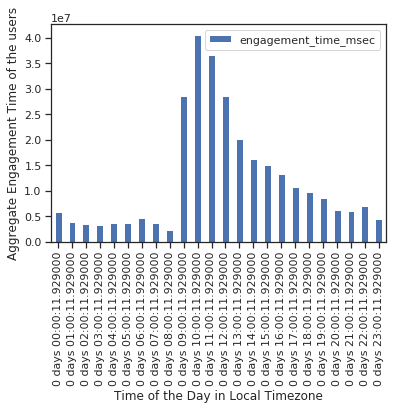

In [166]:
local_time_engagement.resample('1H').sum().plot(kind='bar')
plt.ylabel('Aggregate Engagement Time of the users')
plt.xlabel('Time of the Day in Local Timezone')
plt.savefig('engagement_time_distribution_2.png')
plt.show()

In [30]:
# fg = seaborn.FacetGrid(data=local_time_engagement.groupby('project_id').resample('1H').sum(), hue='project_id', height=2.5, aspect=2.5)
# fg.map(plt.line, 'event_time_of_day_Local', 'engagement_time_msec').add_legend()

seaborn.catplot(x="'event_time_of_day_Local'", y="engagement_time_msec", data=local_time_engagement.groupby('project_id').resample('1H').sum());

ValueError: Could not interpret input ''event_time_of_day_Local''

In [169]:
local_time_engagement['event_time_of_day_Local'] = local_time_engagement.index.seconds.values / 60 / 60

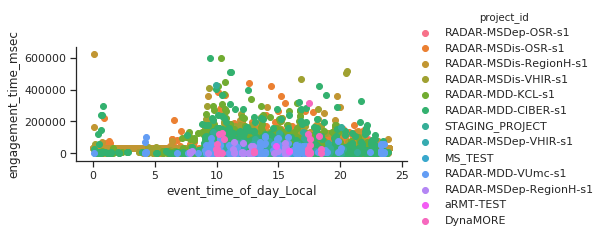

In [170]:
fg = seaborn.FacetGrid(data=local_time_engagement, hue='project_id', height=2.5, aspect=2.5)
fg.map(plt.scatter, 'event_time_of_day_Local', 'engagement_time_msec').add_legend()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


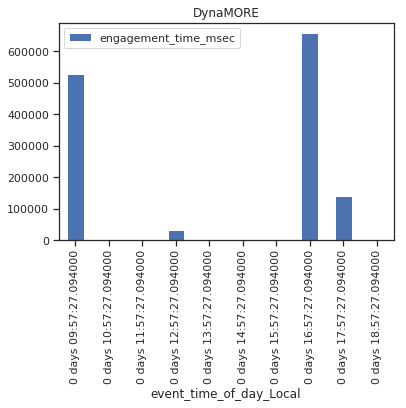

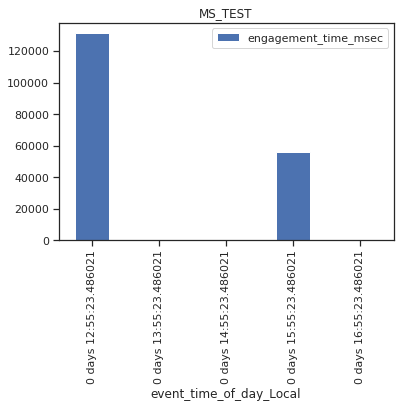

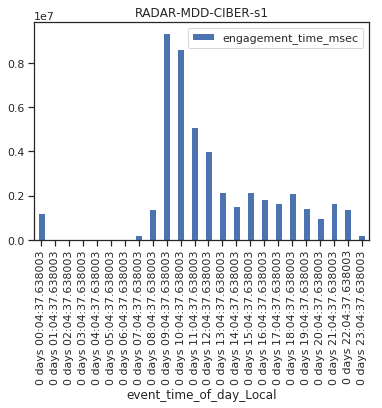

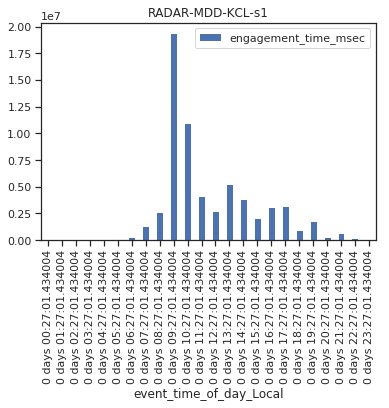

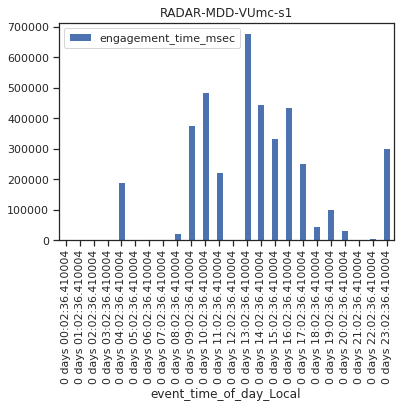

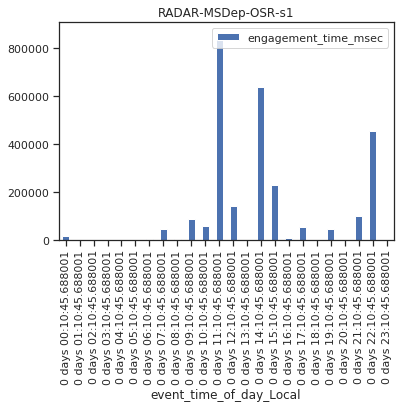

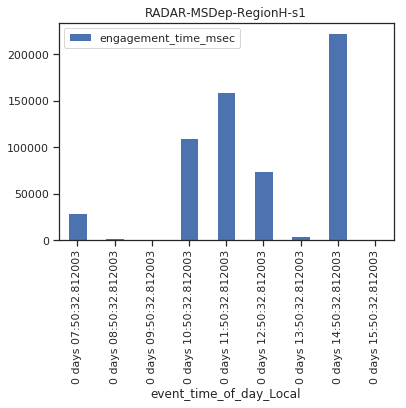

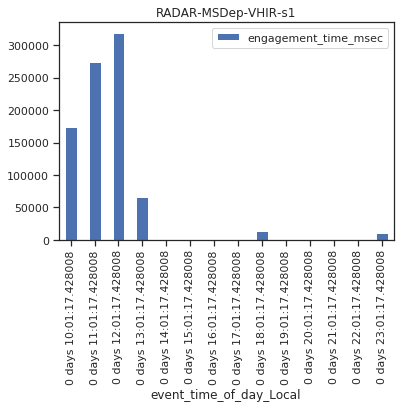

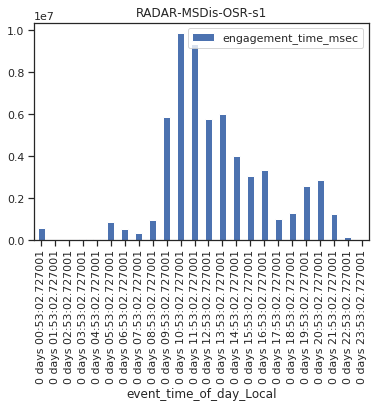

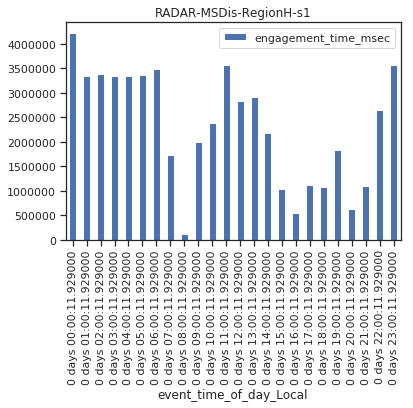

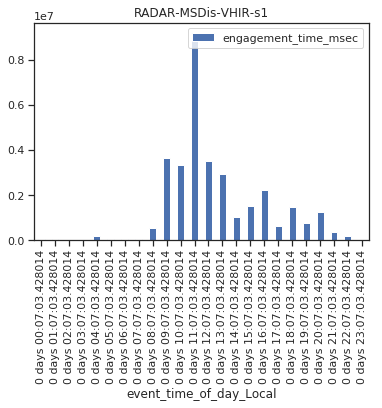

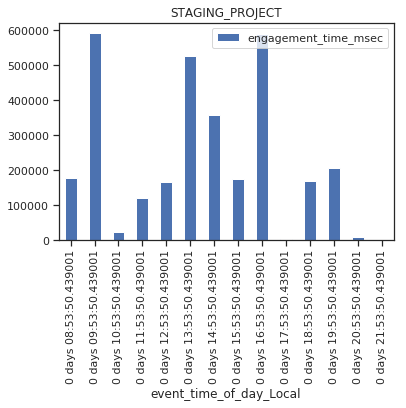

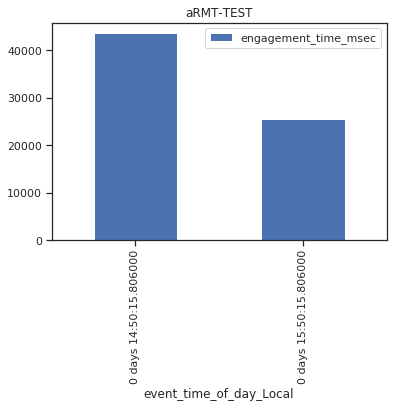

In [167]:
# fig = local_time_engagement.groupby('project_id').resample('1H').sum().plot(kind='bar', subplots=True)
# plt.ylabel('Aggregate Engagement Time of the users')
# plt.xlabel('Time of the Day in Local Timezone')
# plt.show()


grouped = local_time_engagement.groupby('project_id')
# rowlength = int(grouped.ngroups/2)                         # fix up if odd number of groups
# fig, axs = plt.subplots(figsize=(9,4), 
#                         nrows=2, ncols=rowlength,     # fix as above
#                         gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

# targets = zip(grouped.groups.keys(), axs.flatten())
for key, group in grouped:
    print(type(grouped.get_group(key)))
    fig = grouped.get_group(key).resample('1H').sum().plot(kind='bar', title='%s'%key)
    #ax.plot(grouped.get_group(key))
#     ax.set_title('a=%s'%key)
# ax.legend()
plt.show()

In [171]:
local_time_engagement.head()

,event_timestamp,engagement_time_msec,project_id,subject_id,user_pseudo_id,event_time_of_day_Local
event_time_of_day_Local,,,,,,
22:16:48.132009,2019-05-23 20:16:48.132009,91708.0,RADAR-MSDep-OSR-s1,b7564f48-1bf4-4d9e-9925-e165a9325885,e90f9e199b8dd4f8756f46e29bc9934b,22.280000
22:16:54.237014,2019-05-23 20:16:54.237014,6103.0,RADAR-MSDep-OSR-s1,b7564f48-1bf4-4d9e-9925-e165a9325885,e90f9e199b8dd4f8756f46e29bc9934b,22.281667
22:17:25.267017,2019-05-23 20:17:25.267017,31031.0,RADAR-MSDep-OSR-s1,b7564f48-1bf4-4d9e-9925-e165a9325885,e90f9e199b8dd4f8756f46e29bc9934b,22.290278
22:17:55.783021,2019-05-23 20:17:55.783021,15057.0,RADAR-MSDep-OSR-s1,b7564f48-1bf4-4d9e-9925-e165a9325885,e90f9e199b8dd4f8756f46e29bc9934b,22.298611
14:07:13.116004,2019-05-23 12:07:13.116004,4229.0,RADAR-MSDis-OSR-s1,4581e73e-5bcf-45bf-b724-446b5910a23f,a2878cf66bf946623f92c74d66eeefdb,14.120278


In [ ]:
project = 'RADAR-MSDis-RegionH-s1'
grouped_subject = local_time_engagement[local_time_engagement['project_id'] == project].groupby('subject_id')
base_path = 'plots/%s/subjects/engagement_patterns/' % project
import os
if not os.path.exists(base_path):
    os.makedirs(base_path)
    
date_time_interval = pd.timedelta_range(start='0 day', end='1 day', freq='1H')
for key, group in grouped_subject:
    count= pd.DataFrame()
    count['count'] = grouped_subject.get_group(key).resample('H').count()['subject_id']
    plt.figure()
    fig = grouped_subject.get_group(key).resample('H').sum().join(count).plot(kind='bar', title='%s'%key, secondary_y='count')
    plt.savefig('%s/%s.png' % (base_path, key), bbox_inches="tight")
# plt.show()

In [177]:
notification_data = unnested_df[unnested_df['firebase_event_origin'] == 'fcm'][['event_name', 'event_timestamp', 'event_time_of_day_Local' , 'project_id', 'subject_id', 'enrolment_date', 'user_pseudo_id']].compute()

In [190]:
notification_data['event_time_of_day_Local_s'] = notification_data['event_time_of_day_Local'] / np.timedelta64(1, 's')

In [196]:
notification_data = notification_data.set_index('event_time_of_day_Local')

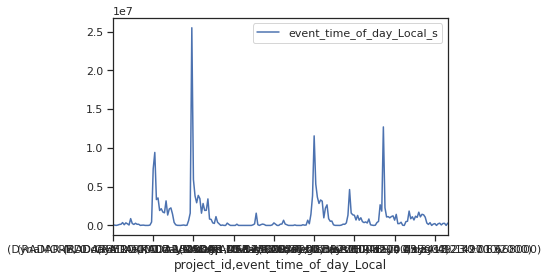

In [209]:
notif_grouped_by_project = notification_data.groupby('project_id')

                         event_name  event_timestamp  project_id  subject_id  \
event_time_of_day_Local                                                        
10:00:07.152000                   2                2           2           2   
11:00:07.152000                   1                1           1           1   
12:00:07.152000                   0                0           0           0   
13:00:07.152000                   1                1           1           1   

                         enrolment_date  user_pseudo_id  \
event_time_of_day_Local                                   
10:00:07.152000                       2               2   
11:00:07.152000                       1               1   
12:00:07.152000                       0               0   
13:00:07.152000                       1               1   

                         event_time_of_day_Local_s  
event_time_of_day_Local                             
10:00:07.152000                                  2  
11:00

                         event_name  event_timestamp  project_id  subject_id  \
event_time_of_day_Local                                                        
09:00:02.573000                  10               10          10          10   
10:00:02.573000                  20               20          20          20   
11:00:02.573000                  22               22          22          22   
12:00:02.573000                   8                8           8           8   
13:00:02.573000                   9                9           9           9   

                         enrolment_date  user_pseudo_id  \
event_time_of_day_Local                                   
09:00:02.573000                      10              10   
10:00:02.573000                      20              20   
11:00:02.573000                      22              22   
12:00:02.573000                       8               8   
13:00:02.573000                       9               9   

                         

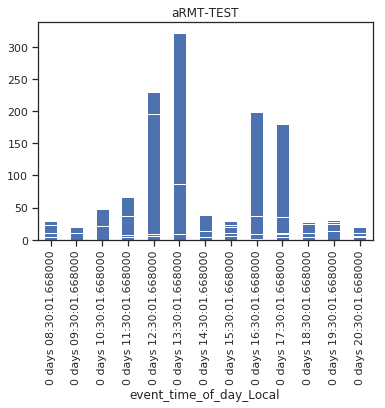

In [210]:
grouped = notification_data.groupby('project_id')
for key, group in grouped:
    group_df = grouped.get_group(key)
    print(group_df[group_df['event_name'] == 'notification_receive'].resample('1H').count().head())
    fig = group_df[group_df['event_name'] == 'notification_receive'].resample('1H').count()['event_timestamp'].plot(kind='bar', title='%s'%key)
plt.show()

In [55]:
seaborn.pairplot(local_time_engagement.query('not project_id.isnull() and not subject_id.isnull()'), vars=['project_id', 'subject_id', 'event_time_of_day_Local', 'engagement_time_msec'], dropna=True)

TypeError: unhashable type: 'numpy.ndarray'

In [76]:
local_time_engagement.index

TimedeltaIndex(['22:16:48.132009', '22:16:54.237014', '22:17:25.267017',
                '22:17:55.783021', '14:07:13.116004', '14:08:20.679004',
                '14:08:25.485005', '11:31:02.463008', '11:31:59.392009',
                '11:32:04.764014',
                ...
                '10:08:23.829058', '10:08:47.276060', '10:08:57.208064',
                '12:07:00.365004', '06:45:40.020001', '23:34:54.561012',
                '22:44:19.629006', '23:38:40.215000', '18:25:26.182003',
                '18:25:45.587009'],
               dtype='timedelta64[ns]', name='event_time_of_day_Local', length=11991, freq=None)

In [126]:
local_time_engagement[['event_time_of_day_Local', 'engagement_time_msec']].corr()

,event_time_of_day_Local,engagement_time_msec
event_time_of_day_Local,1.000000,-0.016161
engagement_time_msec,-0.016161,1.000000


In [72]:
local_time_engagement.head()

,engagement_time_msec,project_id,subject_id,user_pseudo_id
event_time_of_day_Local,,,,
22:16:48.132009,91708.0,RADAR-MSDep-OSR-s1,b7564f48-1bf4-4d9e-9925-e165a9325885,e90f9e199b8dd4f8756f46e29bc9934b
22:16:54.237014,6103.0,RADAR-MSDep-OSR-s1,b7564f48-1bf4-4d9e-9925-e165a9325885,e90f9e199b8dd4f8756f46e29bc9934b
22:17:25.267017,31031.0,RADAR-MSDep-OSR-s1,b7564f48-1bf4-4d9e-9925-e165a9325885,e90f9e199b8dd4f8756f46e29bc9934b
22:17:55.783021,15057.0,RADAR-MSDep-OSR-s1,b7564f48-1bf4-4d9e-9925-e165a9325885,e90f9e199b8dd4f8756f46e29bc9934b
14:07:13.116004,4229.0,RADAR-MSDis-OSR-s1,4581e73e-5bcf-45bf-b724-446b5910a23f,a2878cf66bf946623f92c74d66eeefdb


In [284]:
?grouped_by_subject_id

In [43]:
?local_time_engagement.groupby

In [33]:
dask_df = df.from_pandas(local_time_engagement, npartitions=1)
local_time_engagement.groupby('project_id').resample('1H').mean().unstack(level=0).plot(kind='bar', subplots=True)

ValueError: The level project_id is not valid

In [103]:
?plt.bar

In [1]:
dask_df = df.from_pandas(local_time_engagement)
dask_df.groupby('project_id').plot( kind='line')

NameError: name 'df' is not defined

In [ ]:
client.cancel(unnested_df)

In [ ]:
# Reset the client and delete all variables from the distributed cluter
client.restart()